In [1]:
import pandas as pd # Manejo de bases de datos
import geopandas as gpd # Manejo de bases de datos geográficas
import numpy as np # Funciones numéricas
import matplotlib.pyplot as plt # Gráficas
import seaborn as sns # Gráficas
import datetime as dt
import folium
import unicodedata
import datetime as dt

from geopandas.tools import sjoin
from unicodedata import normalize
from shapely.geometry import LineString, Point

from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier

### Read Bogotá spatial characteristics by city block 

In [2]:
#  Load files
path = '/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Outputs/partial_spatial_block.pkl'
spatial_block = pd.read_pickle(path, compression='gzip')
spatial_block = gpd.GeoDataFrame(spatial_block)
spatial_block.crs = 'EPSG:4326'
spatial_block.to_crs(epsg=4326, inplace=True)
spatial_block = spatial_block[ spatial_block['Area_km2'] < 0.4 ] #Filter out city bloks bigger than 400m^2
Loc_code = list(range(1,20)) #Create localities Id list

### Estimated RT for each locality 

In [3]:
# Reading localities R_t
base_path = '/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/'

loc_R_list = ['usaquen.pkl', 'chapinero.pkl', 'santafe.pkl', 'sancristobal.pkl', 'usme.pkl',
             'tunjuelito.pkl', 'bosa.pkl', 'kennedy.pkl', 'fontibon.pkl', 'engativa.pkl',
             'suba.pkl', 'barriosunidos.pkl', 'teusaquillo.pkl', 'losmartires.pkl', 'antonionariño.pkl',
             'puentearanda.pkl', 'lacandelaria.pkl', 'rafaeluribeuribe.pkl', 'ciudadbolivar.pkl']

R_list = []
# Load data frames, reset index
for i in range(len(loc_R_list)):
    path_file = base_path+loc_R_list[i]
    R_list.append(pd.read_pickle(path_file))
    
for i in range(len(loc_R_list)):
    R_list[i].reset_index(drop=False, inplace=True)

# Create DF containing all RT scores for each locality 
R_df = pd.DataFrame(index = R_list[0]['Time Stamp'])
R_df.reset_index(drop=False, inplace=True)

for i in range(len(loc_R_list)):
    R_df[loc_R_list[i]] = 0
    R_df[loc_R_list[i]] = R_list[i]['R'].tolist()

### Active Cases Count

In [4]:
# Load file
fechas_df = pd.read_csv('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/fechas_sintomas.csv')
fechas_df = fechas_df.rename(columns={'LOCALIDAD_ASIS': 'CASOS_REPORTADOS'})#Rename Column

#Change str to datetime objects
fechas_df['FECHA_DE_INICIO_DE_SINTOMAS'] = pd.to_datetime(fechas_df['FECHA_DE_INICIO_DE_SINTOMAS'], format='%Y-%m-%d')
fechas_df = fechas_df.sort_values(by='FECHA_DE_INICIO_DE_SINTOMAS', ascending=True)
fechas_df = fechas_df.reset_index(drop=True)

#Drop 0 and 21 id codes since they don´t belong to Bogotá geography 
index_0 = fechas_df[ fechas_df['CODIGO_LOCALIDAD'] == 0 ].index
index_21 = fechas_df[ fechas_df['CODIGO_LOCALIDAD'] == 21 ].index

fechas_df.drop(index_0, inplace = True)#drop fuera de bogotá and sin dato rows since we cannot calculate infection 
fechas_df.drop(index_21, inplace = True)# density for them (we don´t know their reference population)

fechas_df = fechas_df.reset_index(drop = True)

com_index = len(fechas_df['FECHA_DE_INICIO_DE_SINTOMAS']) #column length 
start_date = fechas_df.loc[0, 'FECHA_DE_INICIO_DE_SINTOMAS'] #start of the pandemic in Bogotá 
end_date = fechas_df.loc[com_index-1, 'FECHA_DE_INICIO_DE_SINTOMAS'] #Last reported date 

pan_days = end_date - start_date
pan_days = int(pan_days.days) #Days passed since pandemic start to last reported date grid x axis 
local_bog = 20 # number of rows y axis we are not considering 0 and 21 codes 

#create grid and fill it with reported cases y axis correspond to Bogota localities id code, x axis correspond to 
#number of days passed since pandemic started that way 0 index -> 2020-02-06, 1->2020-02-07 and so on

grid = np.ndarray([local_bog, pan_days+1]) #create grid
grid.fill(0) #fill grid with 0 

#Method used to fill grid with reported cases 
def fillGrid(date, code, cases):
    col = date - start_date
    col = int(col.days)
    grid[code-1][col] = cases
    

#Fill grid with cases 
fechas_df.apply(lambda row: fillGrid(row['FECHA_DE_INICIO_DE_SINTOMAS'], row['CODIGO_LOCALIDAD'], int(row['CASOS_REPORTADOS']) ), axis=1)
# Function used to calculate Active cases given a date 
def ActiveCases (date, code):
    col = date - start_date
    col = int(col.days)
    if col >= 15:
        Active = sum(grid[code-1][col-15:col+1])
    else: 
        Active = sum(grid[code-1][0:col+1])
    return int(Active)

### Functions 

In [5]:
#Function used to estimate RT for each city block
def singularizeRT(estrato, popden, hosp, ips, itur, sitp, comer, trips, cases, RT):
    a_rt = RT-estrato+popden-hosp-ips+itur+sitp+comer+trips+cases
    return a_rt

#Function used to estimate cases for each city block 
def single_cases(ppl_block, caseLoc, PobLoc, ID):
    x = (100*caseLoc)/(PobLoc)
    y = (x*ppl_block)/100
    return y


#Prepare a DataFrame to perform classification
def ClassPrepDF(selec_date, selec_str, spatial_block):
    #Add locality Active cases in interest date
    Active_cases = []
    for i in range(len(Loc_code)): #Count Cases
        Active_cases.append(ActiveCases(selec_date, Loc_code[i]))
    # Add Cases 
    spatial_block_date = spatial_block.copy()
    spatial_block_date['cases_'+selec_str] = spatial_block_date.apply(lambda row: Active_cases[row['LOCid']-1], axis=1)
    #Estimate Number of active cases for each city block
    spatial_block_date['block_cases_'+selec_str] = spatial_block_date.apply(lambda row: single_cases(row['ppl_block'], 
                                                                                                          row['cases_'+selec_str], 
                                                                                                          row['PopLoc'], 
                                                                                                          row['LOCid']), axis=1)
    
    #Add RT at locality level for specific date
    rt_list = R_df[ R_df['Time Stamp'] == selec_date ]
    rt_list = rt_list.iloc[:, 1:].values.tolist()[0]
    spatial_block_date['Rt_'+selec_str] = spatial_block_date.apply(lambda row: rt_list[row['LOCid']-1], axis=1)
    #Drop cols we dont need anymore
    spatial_block_date.drop(columns={'cases_'+selec_str, 'PopLoc'}, inplace=True)
    #Calculate RT for city block
    spatial_block_date_rt = spatial_block_date.copy()
    spatial_block_date_rt['ESTRATOPre'] = spatial_block_date_rt['ESTRATOPre']/(spatial_block_date_rt['ESTRATOPre'].max()*4)
    spatial_block_date_rt['BlockPopDen'] = spatial_block_date_rt['BlockPopDen']/(spatial_block_date_rt['BlockPopDen'].max()*4)
    spatial_block_date_rt['N_Hosp'] = spatial_block_date_rt['N_Hosp']/(spatial_block_date_rt['N_Hosp'].max()*4)
    spatial_block_date_rt['N_IPS'] = spatial_block_date_rt['N_IPS']/(spatial_block_date_rt['N_IPS'].max()*4)
    spatial_block_date_rt['N_ITur']  = spatial_block_date_rt['N_ITur']/(spatial_block_date_rt['N_ITur'].max()*4)
    spatial_block_date_rt['N_SITP'] = spatial_block_date_rt['N_SITP']/(spatial_block_date_rt['N_SITP'].max()*4)
    spatial_block_date_rt['N_Ecomer'] = spatial_block_date_rt['N_Ecomer']/(spatial_block_date_rt['N_Ecomer'].max()*4)
    spatial_block_date_rt['total_trips'] = spatial_block_date_rt['total_trips']/(spatial_block_date_rt['total_trips'].max()*4)
    spatial_block_date_rt['block_cases_'+selec_str] = spatial_block_date_rt['block_cases_'+selec_str]/(spatial_block_date_rt['block_cases_'+selec_str].max()*3)
    
    spatial_block_date_rt['BlockRT_'+selec_str] = spatial_block_date_rt.apply(lambda row: singularizeRT(row['ESTRATOPre'], 
                                                                                       row['BlockPopDen'], row['N_Hosp'],
                                                                                       row['N_IPS'], row['N_ITur'],
                                                                                       row['N_SITP'], row['N_Ecomer'],
                                                                                       row['total_trips'], 
                                                                                       row['block_cases_'+selec_str],
                                                                                       row['Rt_'+selec_str]), axis=1)
    
    # Finally generate final normalized DF with an estimated rt for each city block
    spatial_block_date['BlockRT_'+selec_str] = spatial_block_date_rt['BlockRT_'+selec_str]
    spatial_block_date['ESTRATOPre'] = spatial_block_date['ESTRATOPre']/(spatial_block_date['ESTRATOPre'].max())
    spatial_block_date['BlockPopDen'] = spatial_block_date['BlockPopDen']/(spatial_block_date['BlockPopDen'].max())
    spatial_block_date['N_Hosp'] = spatial_block_date['N_Hosp']/(spatial_block_date['N_Hosp'].max())
    spatial_block_date['N_IPS'] = spatial_block_date['N_IPS']/(spatial_block_date['N_IPS'].max())
    spatial_block_date['N_ITur']  = spatial_block_date['N_ITur']/(spatial_block_date['N_ITur'].max())
    spatial_block_date['N_SITP'] = spatial_block_date['N_SITP']/(spatial_block_date['N_SITP'].max())
    spatial_block_date['N_Ecomer'] = spatial_block_date['N_Ecomer']/(spatial_block_date['N_Ecomer'].max())
    spatial_block_date['total_trips'] = spatial_block_date['total_trips']/(spatial_block_date['total_trips'].max())
    spatial_block_date['block_cases_'+selec_str] = spatial_block_date['block_cases_'+selec_str]/(spatial_block_date['block_cases_'+selec_str].max())
    spatial_block_date['BlockRT_'+selec_str] = spatial_block_date['BlockRT_'+selec_str]/(spatial_block_date['BlockRT_'+selec_str].max())
    # Drop cols we dont need anymore
    spatial_block_date.drop(columns={'Rt_'+selec_str}, inplace=True)
    
    return spatial_block_date
    

In [6]:
# Classifier Training Function 
# model -> NN for MultiLayerPerceptron Neural Netowrok, 
# RF for RandomForest, KNN for K Nearest Neighbors 
def TrainClassificator(model):
    TrainDF = pd.read_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Outputs/TrainClass.pkl')
    XTrain = TrainDF.drop(columns={'labels'})
    Xmat = XTrain.to_numpy()
    Yl = TrainDF['labels'].to_numpy()
    if model == 'NN':
        NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(), random_state=1)
        NN.fit(Xmat, Yl)
        return NN
    
    elif model == 'KNN':
        KNN = neighbors.KNeighborsClassifier(n_neighbors=16, weights='distance', algorithm='auto')
        KNN.fit(Xmat, Yl)
        return KNN
    
    elif model == 'RF':
        RF = RandomForestClassifier(random_state=0)
        RF.fit(Xmat, Yl)
        return RF
        
    else:
        raise ValueError('model argument must be NN, KNN or RF')

### Train Classificator

In [7]:
# Contagion peak dates from epidemic curve in Bogotá
date_list = ['01/05/2020' ,'01/08/2020', '01/11/2020', '10/01/2021', '10/03/2021', '01/05/2021',
             '20/06/2021', '01/09/2021']

date_list2 = ['01-05-2020' ,'01-08-2020', '01-11-2020', '10-01-2021', '10-03-2021', '01-05-2021',
             '20-06-2021', '01-09-2021']

In [8]:
# Train Classificator 
CLF = TrainClassificator(model='NN')

### Risk Estimation

In [9]:
#Select date and prepare DF to Stratify Risk
o = 7
selec_date = date_list[o]
selec_str = date_list2[o]
selec_date = dt.datetime.strptime(selec_date, "%d/%m/%Y")

cityBlockDF = ClassPrepDF(selec_date, selec_str, spatial_block) # Prepare DF

In [10]:
# Construct Matrix
Xdf = cityBlockDF.drop(columns={'MANCODIGO', 'ppl_block', 'Area_km2', 'BlockPopDen', 'geometry',
                               'N_Hosp', 'N_IPS', 'N_ITur', 'N_SITP', 'N_Ecomer', 'UTAM', 'LOCid',
                               'ESTRATOPre', 'total_trips'})

Xmat = Xdf.to_numpy()
labels = CLF.predict(Xmat)
cityBlockDF['RiskStrat'] = labels

In [32]:
# Optionally save DF if needed 
#path = '/home/ubuntu/javeriana/MOTUS-PUJ/Bog_Estimation/reg_ml/ClassDFs/Labeled/'
#cityBlockDF.to_pickle(path+'date_'+selec_str+'.pkl', compression='gzip')

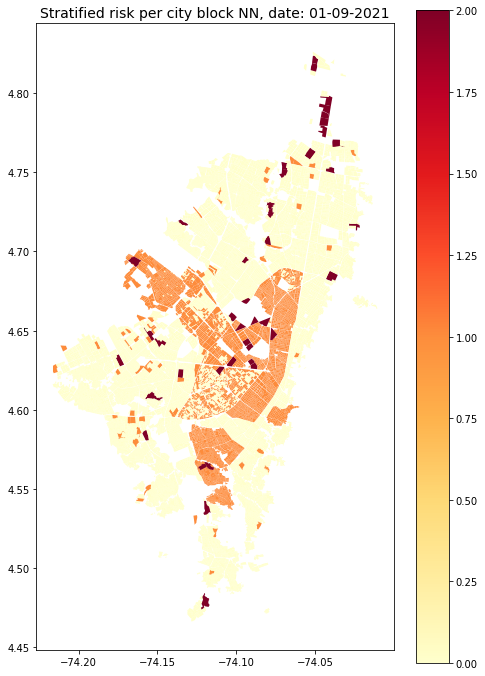

In [11]:
# Plot risk stratification map
cityBlockDF.plot(column='RiskStrat', cmap='YlOrRd', figsize=(8,12), legend=True);
plt.title('Stratified risk per city block NN, date: '+selec_str, fontsize=14);
plt.savefig('/home/ubuntu/javeriana/MOTUS-PUJ/Step_3/Outputs/date_'+selec_str+'.jpg')

### Route Risk

In [12]:
Origen = (4.728809332980472, -74.06880833463508) #Route Origin
Destino = (4.62894499452047, -74.06466808542737) #Route Destiny
# Peak dates from epidemic curve
peak_dates4 = ['2020-05-01' ,'2020-08-01', '2020-11-01', '2021-01-10', '2021-03-01', '2021-05-01',
             '2021-06-10', '2021-09-01']

sd = 5 # select date 
# Here api key
API_key = '1NGxYsCA_oIhkYX-tv9HgZ3XH3tEc8rGBzQt0fz-OYY'
#### ------- Latitude, longitude ----- ###### 
Inicio = str(Origen[0])+','+str(Origen[1]) #Start
Final = str(Destino[0])+','+str(Destino[1]) #end
##### ----------- Mode -------- ########
# ---- car, pedestrian	, publicTransport, truck, bicycle
Modo = 'publicTransport'
# --- Walking speed --- ### 
#Velocidad_caminar = 1.4
#Velocidad_caminar = '&walkSpeed=' + str(Velocidad_caminar)

### ------ time analysis ---- #### 
#Tiempo = dt.datetime.strptime('2020-06-12 14:00:00','%Y-%m-%d %H:%M:%S')
Tiempo = dt.datetime.strptime(peak_dates4[sd]+' 15:00:00', '%Y-%m-%d %H:%M:%S')
Tiempo=Tiempo.strftime('%Y-%m-%dT%H:%M:%S')
Tiempo = '&departure='+str(Tiempo)

##### -------- route type ----- ####### 
## Fastest: Más rapida 
## shortest: Más Corta 
## balanced: Balanceada
Tipo_ruta = 'balanced'

In [13]:
####### ------- request -------- #####
built_url = 'https://route.ls.hereapi.com/routing/7.2/calculateroute.json?apikey='+API_key+'&waypoint0=geo!'+Inicio+'&waypoint1=geo!'+Final+'&mode='+Tipo_ruta+';'+Modo+';traffic:enabled&legattributes=li&c&returnelevation=true&metricSystem=imperial'+str(Tiempo)
html_data = pd.read_json(built_url)
Datos_ruta = pd.DataFrame(pd.DataFrame(pd.DataFrame(html_data.T['route'].iloc[0])['leg'].iloc[0])['link'].iloc[0])
Datos_ruta = pd.DataFrame(pd.concat([pd.DataFrame(x)[0] for x in Datos_ruta['shape']]))[0].reset_index(drop=True)
Latitudes = pd.DataFrame({'latitude': Datos_ruta.apply(lambda x: float(x.split(',')[0])),'longitude': Datos_ruta.apply(lambda x: float(x.split(',')[1]))})
Ruta_here  = LineString(list(Latitudes.apply(lambda x: (x['longitude'],x['latitude']),axis=1)))

In [14]:
# Get route lineString and buffer it 
line_gdf = gpd.GeoDataFrame(geometry=[Ruta_here])
line_gdf['geometry'] = line_gdf['geometry'].buffer(0.00009)
# Perform sjoin to check city blocks that are adjacent to route
RB_join = gpd.sjoin(line_gdf, cityBlockDF, op="intersects")
RB_join.crs = "EPSG:4326"
RB_join.to_crs(epsg=4326, inplace=True)

/home/ubuntu/.pyenv/versions/3.7.5/envs/motus/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  """


In [15]:
# calculate Route Risk
Route_Risk = sum(RB_join['RiskStrat'].values.tolist())/len(RB_join['RiskStrat'].values.tolist())
Route_Risk

0.031007751937984496